# Random LDPC Codes And Their Reductions
---

### <u> **Sections** </u>

1. Create a random classical LDPC code with specified parameters.
2. Create a "random" HGP code by taking the HGP of (1) with itself.
3. Reduce the HGP code of (2) using the reduction procedure of Section _.
4. Transformation Analysis. Used to obtainthe results of Table _.

### Imports

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import csc_matrix, csr_matrix, lil_matrix
from bposd.hgp import hgp
from bposd.css import css_code
from ldpc.code_util import compute_code_parameters, compute_exact_code_distance
from ldpc.mod2 import rank
from networkx.algorithms.bipartite import configuration_model, biadjacency_matrix
from matplotlib import rcParams
rcParams['font.size'] = 14
rcParams['text.usetex'] = True

## Section 1: Create a random classical LDPC code with specified parameters

***

### <u>**Helper functions:** Creating and coloring check-adjacency graph (Equivalently, bit-adjacency graph of the transpose code)</u>

The reason for creating this graph for the purposes of the reduction is detailed in Section _.

<img src="./Figs/becolor.svg" alt="Bit-Edge coloring" width="500">

**(a)** Tanner graph example for $H=\begin{pmatrix} 1 & 1 & 0 \\ 0 & 1 & 1 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{pmatrix}$.

**(b)** Tanner graph for $H^T=\begin{pmatrix} 1 & 0 & 0 & 0 \\ 1 & 1 & 1 & 0 \\ 0 & 1 & 0 & 1 \end{pmatrix}$. 

**(c)** Check-adjacency graph for the Tanner graph in (a), where edges between vertices exist iff corresponding checks share a common bit. Equivalently, the bit-adjacency graph for the Tanner graph in (b). Edges exist between vertices iff corresponding bits share a common check. 

**(d)** Example coloring of the graph in (c). Vertices in the same color mean that their corresponding checks in (a) do not share a bit in common, and that their corresponding bits in (b) do not share a check in common.

**(e)** Correlation between the colors in (d) and the checks of (a), where checks in the same color do not share a bit in common.


In [29]:
def get_check_adj_graph(H):
    # 1 if checks share a bit; 0 otherwise
    # #checks x #checks
    checkadjmatrix = (H @ H.T != 0).astype(int)
    
    # Diagonal is always 0
    np.fill_diagonal(checkadjmatrix, 0)

    # Then create the graph
    G = nx.from_numpy_array(checkadjmatrix, create_using=nx.MultiGraph())
    
    return G


def get_check_coloring(H):
    
    # Get the check-adjacency graph
    G = get_check_adj_graph(H)
    
    # Color the check-adjacency graph -- returns a dictionary
    color_dict = nx.greedy_color(G, strategy='independent_set')
    
    # Return the coloring in the following 2D-list format:
    # [[list of checks with color 0], [list of checks with color 1], ...] (See example below)
    num_colors = max(list(color_dict.values())) + 1
    coloring = []
    for i in range(num_colors):
        coloring.append([key for key, value in color_dict.items() if value == i])
        
    return coloring

### <u> Creating the random classical LDPC code </u>

We specify:

* $n$ : number of bits in the classical code
* $d_v$: how many checks each bit participates in
* $d_c$: how many bits each check involves
* `min_dist`: minimum distance $d$ of the random classical code
* `max_coloring`: maximum coloring of the classical checks
* `tries`: maximum number of random codes generated to meet the constraints of $H$ being full rank as well as `min_dist` and `max_coloring`

We use the bipartite configuration model of NetworkX to create our random LDPC code.

> **Bipartite Configuration Model**: Creates a random bipartite graph $G = (B \cup C, E)$ by randomly matching edges between $B$ and $C$ while maintaining $d_v$, $d_c$ constraints. We infer this graph as a Tanner graph where $B$ is the set of bits and $C$ is the set of checks, which we can convert to a classical parity check matrix for our code. (Equivalently, we could insert 0s and 1s randomly into a $m \times n$ patrix check matrix while keeping the max row (column) weight as $d_c$ ($d_v$).)
> 
> <img src="./Figs/configmodel.svg" alt="Config model" width="200">

***Enforcing full rank classical parity-check matrix here**. This is an assumption of the reduction.

In [30]:
### Parameters
n = 30
d_v = 5
d_c = 6 
min_dist = 13
max_coloring = 9
tries = 10000

# Keep iterating to find a code that keeps all constraints
for i in range(tries):
        
    # Number of checks
    m = int(n * d_v / d_c)
    
    # Random bipartite graph that we model as the Tanner graph
    graph = configuration_model(
        d_v*np.ones(n,dtype=int), 
        d_c*np.ones(m,dtype=int), 
        create_using=nx.Graph())
    
    # create PCM from Tanner graph
    H = biadjacency_matrix(graph, row_order=np.arange(n)).T.toarray()
    
    # (1) *ensure the H is full rank, (2) make sure that the code distance is
    # >= `min_dist`, (3) make sure that the coloring is <= `max_coloring`
    d = compute_exact_code_distance(H)
    #print(f"distance: {d}")
    if d >= min_dist and rank(H) == H.shape[0]:
        coloring = get_check_coloring(H)
        #print(f"# colors: {len(coloring)}")
        if len(coloring) <= max_coloring:
            break
print(f"Classical code: [n, k, d] = {compute_code_parameters(H)}")

Classical code: [n, k, d] = (30, 5, 13)


### <u> Drawing the Classical Tanner graph (Directly from Configuration Model) </u>

- Left set of nodes are the bits; right set of nodes are the checks

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]


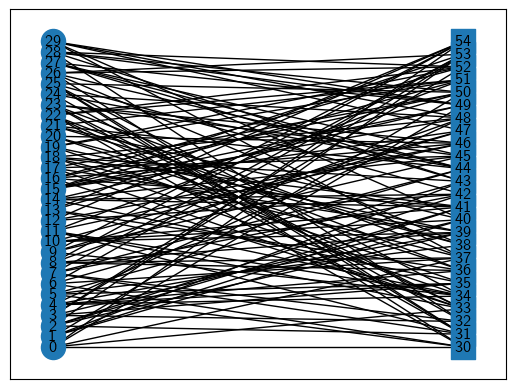

In [31]:
import matplotlib.pyplot as plt
import networkx as nx

vars = list(range(n))
print(graph.nodes())
checks = [v for v in graph.nodes() if v not in vars]

pos = nx.bipartite_layout(graph, vars)
nx.draw_networkx_nodes(graph, pos, nodelist=vars, node_shape='o')
nx.draw_networkx_nodes(graph, pos, nodelist=checks, node_shape='s')
nx.draw_networkx_edges(graph, pos)
nx.draw_networkx_labels(graph, pos)

plt.show()


### <u> Coloring the classical checks </u>

- `coloring[i]` contains the bit(s) in color group `i`
- Example:
$$\big[\underbrace{[8, 1, 4, 7]}_{\rm group\ 0}, \underbrace{[0, 3, 6]}_{\rm group\ 1}, \underbrace{[2]}_{\rm group\ 2}, \underbrace{[5]}_{\rm group\ 3}\big]$$

* Means:
    * color group 0: bit(s) 8, 1, 4, 7
    * color group 1: bit(s) 0, 3, 6
    * color group 2: bit(s) 2
    * color group 3: bit(s) 5

<img src="./Figs/classicalcolor.svg" alt="Classical coloring" width="400">

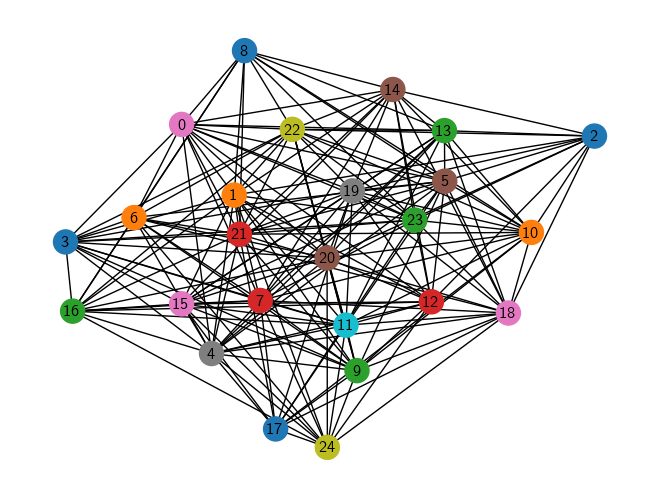

In [32]:
### Coloring + checks
coloring = get_check_coloring(H)
#print(f"Check coloring: {coloring}")
G_checks = get_check_adj_graph(H)

# Creating random colors for the graph
color_map = {}
for color_idx, group in enumerate(coloring):
    for check in group:
        color_map[check] = color_idx
node_colors = [color_map[i] for i in G_checks.nodes()]

# Graphing the colored check-adjacency graph 
# (nodes are checks, edges between nodes mean that the checks share a bit)
# (nodes in the same color mean that no bits are shared in common between those checks)
pos = nx.spring_layout(G_checks, seed=0)
nx.draw(G_checks, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.tab10)
plt.show()

## Section 2: Create a "random" HGP code by taking the HGP of Section 1 with itself.

***

### <u> Hypergraph Product </u>

Now we create the hypergraph product of this random classical LDPC code with itself:

<img src="./Figs/hgp.svg" alt="HGP" width="300">

(Edges omitted)

In [33]:
# Create HGP and confirm that it is a valid CSS code
code = hgp(h1=H, h2=H, compute_distance=True)
code.name = 'Random Code HGP'
code.test()

Random Code HGP
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -Random Code HGP is a valid CSS code w/ params [1525,25,13]


True

### <u> **Helper:** Draws check-type Tanner graph. </u>

* Draws the quantum Tanner graph of an HGP code
* Contains both X and Z stabilizers 
* This function draws the Tanner graph for a subset of qubits ONLY (indices `ctype_start_idx` to $n$). Since we are only removing check-type qubits in the reduction, we will naturally input the index of the first check-type qubit (will help us confirm that the transformation is working)
* The other parameter `ctypes` will be a list of indices between [`ctype_start_idx`, $n$] such that edges in the Tanner graph will ONLY be drawn for qubits in this set. Will remove clutter from the visualization.

In [34]:
import numpy as np
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt

# ctype_start_idx : index of first check-type qubit
# ctypes : set of indices of check-type qubit whose EDGES are drawn in the graph
def ctype_tannergraph(hx, hz, ctype_start_idx, ctypes):
    """
    Draws the Tanner graph for a given set of check-type qubits.
    
    ctype_start_idx : index of first qubit to include in the graph. The graph will include all qubits beyond this index.
    ctypes : set of indices of qubits within [ctype_start_idx, n] whose EDGES are drawn in the graph.
    """
    assert hx.shape[1] == hz.shape[1]
    
    n = hx.shape[1]
    mx = hx.shape[0]
    mz = hz.shape[0]

    # Graph nodes
    ctype_cols = np.arange(ctype_start_idx, n)
    ctype_set = set(ctype_cols.tolist())
    q_nodes = list(ctype_cols) # [ctype_start_idx, n]
    x_nodes = list(range(n, n + mx)) # [n, n+mx]
    z_nodes = list(range(n + mx, n + mx + mz)) # [n+mx, n+mx+mz]
    G = nx.Graph()
    G.add_nodes_from(q_nodes, bipartite=0, kind='qubit')
    G.add_nodes_from(x_nodes, bipartite=1, kind='X')
    G.add_nodes_from(z_nodes, bipartite=1, kind='Z')

    # hx edges
    coords = hx.tocoo()
    for r, c, v in zip(coords.row, coords.col, coords.data): 
        if v % 2 != 0 and c in ctype_set and c in ctypes:
            G.add_edge(n + r, c)
            
    # hz edges
    coords = hz.tocoo()
    for r, c, v in zip(coords.row, coords.col, coords.data):
        if v % 2 != 0 and c in ctype_set and c in ctypes: # just looking at one qubit
            G.add_edge(n + mx + r, c)

    # Draw & label the graph
    pos = nx.bipartite_layout(G, q_nodes)
    nx.draw_networkx_nodes(G, pos, nodelist=q_nodes, node_shape='o', node_color='lightgreen', label='check-type qubits')
    nx.draw_networkx_nodes(G, pos, nodelist=x_nodes, node_shape='s', node_color='salmon', label='X stabilizers')
    nx.draw_networkx_nodes(G, pos, nodelist=z_nodes, node_shape='s', node_color='lightblue', label='Z stabilizers')
    nx.draw_networkx_edges(G, pos, alpha=0.6)
    labels = {q: f"q{q}" for q in q_nodes}
    labels.update({n + r: f"X{r}" for r in range(mx)})
    labels.update({n + mx + r: f"Z{r}" for r in range(mz)})
    nx.draw_networkx_labels(G, pos, labels, font_size=6)
    plt.show()

## Section 3: Reduce the HGP code of Section 2 and analyze the reduction's performance. Used to obtainthe results of Table _.

***

Now we implement the qubit reduction procedure of Section _. We divide this section in to the following steps:
1. Isolate the check-type qubits into color groups
2. Determine the color groups that we combine $X$ and $Z$ stabilizers within
3. Combine stabilizers within the color groups

### <u> Step 1: Isolate the check-type qubits into color groups </u>

Idea:
* Sector check-type qubits into color groups:
* Output: A dictionary 
    - Key: color group index
    - Value: list of qubit coordinates in that color groups.

Example:

<img src="./Figs/hgpexcolor.svg" alt="HGP" width="400">

Color groups are 0-indexed reading left-to-right top-to-bottom; see orange numbers in the center (group 0 is red-red, group 1 is blue-red, etc.)

Qubits are 0-indexed by coordinate system with origin at the top-left increasing left-to-right top-to-bottom (e.g., the 4 qubits in color group 0 have coordinates (0, 0), (0, 1), (1, 0), (1, 1))

So we should have
$$\begin{aligned}\texttt{color\_groups = } \{&0 : [(0, 0), (0, 1), (1, 0), (1, 1)], \\ &1 : [(0, 2), (1, 2)], \\ &2 : [(0, 3), (0, 4), (1, 3), (1, 4)], \\ &3 : [(2, 0), (2, 1)], \\ &4 : [(2, 2)], \\ &5 : [(2, 3), (2, 4)], \\ &6 : [(3, 0), (3, 1), (4, 0), (4, 1)], \\ &7 : [(3, 2), (4, 2)], \\ &8 : [(3, 3), (3, 4), (4, 3), (4, 4)]\}\end{aligned}$$

In [35]:
m, n = H.shape
    
# bit- and check-type qubit indices
bit_type = np.arange(0, n*n)
check_type = np.arange(n*n, n*n + m*m)

color_groups = {}
for group1 in coloring:
    for group2 in coloring:
        length = len(color_groups)
        color_groups[length] = []
        for c1 in group1:
            for c2 in group2:
                color_groups[length].append((c1, c2))
        
#print(f"HGP color groups indexed by qubit coordinate: {color_groups}")
    

### <u> Step 2: Determine the color groups that we combine $X$ and $Z$ stabilizers within </u>

Here we follow the optimization procedure of Section _.

Recall that the color groups are defined by indices `0`, `1`, `2`, `3`, `...`, `len(color_groups)-1`

We could, as we describe in Section _:
  * combine $Z$ on color groups `0`, `len(coloring) + 1`, `2*len(coloring) + 2`, `3*len(coloring) + 3`, `...`, and
  * combine $X$ on color groups `1`, `len(coloring)`, `2*len(coloring) + 3`, `3*len(coloring) + 2`, `...`

like as follows for our example (big red $\Huge\textcolor{red}{X}$ ($\Huge\textcolor{blue}{Z}$) in the middle means we combine $X$ ($Z$) stabilizers in that color group):

<img src="./Figs/hgpexpreoptimized.svg" alt="HGP" width="400">

However, this does not remove the optimal number of check-type qubits.

**Optimization procedure:**

* Since we take the HGP of the same classical code, a if the classical checks are $\chi$-colorable, there are $\chi^2$ check-type color groups
* Recall that we reduce this optimization problem to maximum weight matching on a bipartite graph, solvable in polynomimal time
* We construct the bipartite graph with $2\chi+\chi^2$ vertices and edge using `color_groups_to_bipartite_graph`, perform matching on this graph using `max_weight_matching`, and use the matching to extract the color groups that we combine on using `extract_combine_schedule_from_matching`

The graph for our example would look like (a) in the following image, and a maximum weight matching would look like (b) (edges and vertices in $\textcolor{red}{\text{red}}$ are included in the matching):

<img src="./Figs/hgpreductiongraph.svg" alt="HGP" width="400">

Extracting the solution from the matching in (b), we get $\texttt{Xcombines = [0, 5, 6]}$ and $\texttt{Zcombines = [1, 3, 8]}$ which looks like the following:

<img src="./Figs/hgpexoptimized.svg" alt="HGP" width="400">

In [36]:
def color_groups_to_bipartite_graph(color_groups):
    """
    Build the bipartite graph used in the reduction.
    """
    k = int(round(np.sqrt(len(color_groups))))
    assert k * k == len(color_groups)
    G = nx.Graph()

    # 2k + k^2 bipartite nodes
    rowcol_nodes = [f"X{i}" for i in range(k)] + [f"Z{i}" for i in range(k)]
    color_nodes = [i for i in range(k**2)]
    G.add_nodes_from(rowcol_nodes, bipartite=0)
    G.add_nodes_from(color_nodes, bipartite=1)

    # X (row) edges
    for i in range(k): # for each X-node Xi
        for j in range(k): # will connect to k color nodes
            color_idx = (i * k) + j
            w = len(color_groups[color_idx])
            G.add_edge(f"X{i}", color_idx, weight=w)

    # Z (column) edges
    for i in range(k): # for each Z-node Zi
        for j in range(k): # will connect to k color nodes
            color_idx = (j * k) + i
            w = len(color_groups[color_idx])
            G.add_edge(f"Z{i}", color_idx, weight=w)

    return G

def max_weight_matching(G):
    """
    Find the maximum weight matching of G.
    """
    matching = nx.max_weight_matching(G, maxcardinality=True)
    # Format: e.g., {("X0", 7), ("Z1", 3), ...} (order not guaranteed)
    return matching

def extract_combine_schedule_from_matching(matching):
    """
    Extract the schedule of which stabilizers to combine given a matching.
    """
    k = len(matching) // 2
    mate = {}
    for u, v in matching:
        mate[u] = v
        mate[v] = u
        
    # {("X0", 7), ("Z1", 3), ...} -> {X0: 7, Z1: 3, ...}
    Xcombines = [mate[f"X{i}"] for i in range(k)]
    Zcombines = [mate[f"Z{j}"] for j in range(k)]
    return Xcombines, Zcombines

Xcombines, Zcombines = extract_combine_schedule_from_matching(max_weight_matching(color_groups_to_bipartite_graph(color_groups)))
#print(f"Color group indices to combine X stabilizers: {Xcombines}")
#print(f"Color group indices to combine Z stabilizers: {Zcombines}")

baseXcombines = [i*len(coloring) + i for i in range(len(coloring))]
baseZcombines = [i*len(coloring) + (i+1 if i%2 == 0 else i-1) for i in range(len(coloring) - 1)]
tot = 0
for i in baseXcombines + baseZcombines:
    weight = len(color_groups[i])
    tot += weight
print(f"With the baseline schedule, we remove {tot} check-type qubits.")

tot = 0
for i in Xcombines + Zcombines:
    weight = len(color_groups[i])
    tot += weight
print(f"With the optimized schedule, we remove {tot} check-type qubits.")


With the baseline schedule, we remove 151 check-type qubits.
With the optimized schedule, we remove 200 check-type qubits.


### <u> Step 3: Combine stabilizers within the color groups </u>

We continue off our previous example:

<img src="./Figs/hgpexremove.svg" alt="HGP" width="400">

Let the purple numbers next to $X$ stabilizers indicate the index of the corresponding row of that stabilizer in $H_X$. Let the orange number inside each color group denote the index of that color group in $\texttt{color\_groups}$.

High-level idea, which leads us to creating two helper functions:

* Coordinate $(a, b)$ corresponds to qubit index $n^2 + ma + b$ in $H_X$ and $H_Z$. For example, the qubit with connected stabilizer edges in the above figure is coordinate $(1, 1)$. Since $n=m=5$, we have that it's index is $5^2 + 5(1) + 5 = 35$. 

* Then, $\texttt{stabs\_touching\_qubit(Hx, 35) = [5, 6, 8]}$ (indices of $X$ stabilizers connected to that qubit). As per the transformation, we then combine stabilizers 5 and 6, then 6 and 8 (repetition-code style). We do this by calling $\texttt{combinerowsF2(Hx, [5, 6, 8])}$. This will remove $X$ support off qubit $(1, 1)$. We can then cut $Z$ support and discard the qubit.

In [37]:
def stabs_touching_qubit(H, q):
    """
    Returns the indices of the stabilizers that touch a given qubit index.
    """
    return H[:, q].nonzero()[0]

def combinerowsF2(H, stab_indices):
    """
    For each i in stab_indices, combines rows H[i] and H[i+1] over F2. 
    
    H : PCM (code.hx or code.hz)
    stab_indices : indices of rows to be combined repetition-code style
    """
    #if len(stab_indices) < 2:
        #return H
    
    stab_indices = list(stab_indices)

    for k in range(len(stab_indices) - 1):
        # Get adjacent elements in stab_indices
        i = stab_indices[k]
        j = stab_indices[k + 1]

        # Corresponding rows to be added together
        ri = H.getrow(i).toarray()[0]
        rj = H.getrow(j).toarray()[0]

        H[i, :] = (ri ^ rj).astype(int)  # add rows over F2

    # Delete last stabilizer row, since one stabilizer is always removed
    last_row = stab_indices[-1]
    m, n = H.shape
    keep_rows = [r for r in range(m) if r != last_row]
    H_new = H[keep_rows, :][:, :].tocsr()
    
    return H_new


### Test of the above helper functions

* We try to combine Z stabilizers on the first check-type qubit (index $n^2$)

Before combining


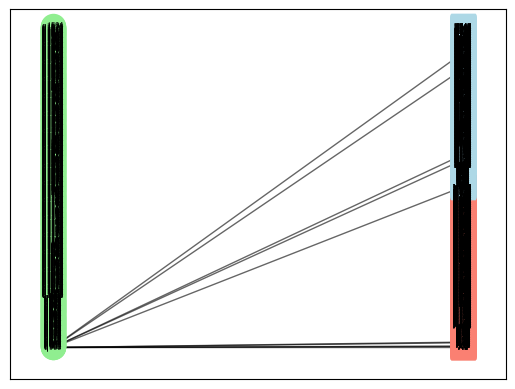

After combining


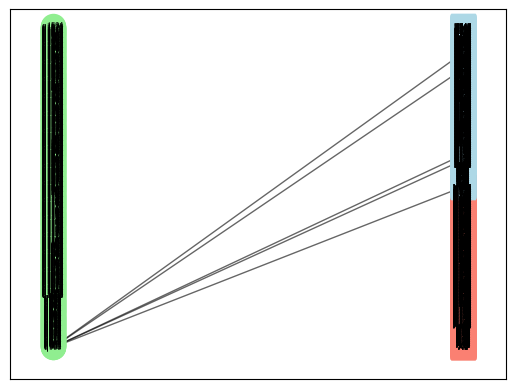

In [38]:
print("Before combining")
ctype_tannergraph(code.hx, code.hz, n**2, [n**2])
Hxnew = combinerowsF2(code.hx, stabs_touching_qubit(code.hx, n**2))
print("After combining")
ctype_tannergraph(Hxnew, code.hz, n**2, [n**2])

### Performing the combining

Now we must combine $X$ ($Z$) stabilizers within the check-type color groups in `Xcombines` (`Zcombines`).

* All we need to do is call `combinerowsF2()` for the stabilizers returned from `stabs_touching_qubit`, for each qubit in each color group

To visualize that the transformation is working, we call `ctype_tannergraph`. `Xgroups` (`Zgroups`) in the below code holds the qubit indices for all of the check-type qubits in the color groups of `Xcombines` (`Zcombines`), so that we can notice if those qubits in particular lose `X` (`Z`) support.

Pre-X reduction


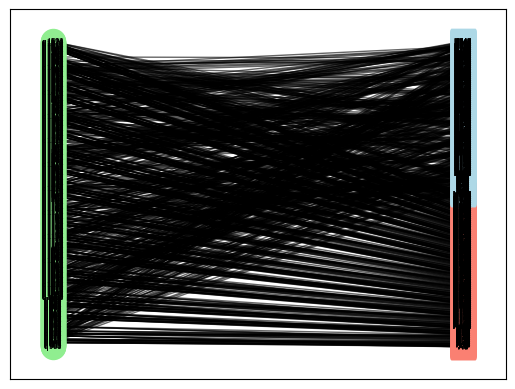

Post-X reduction


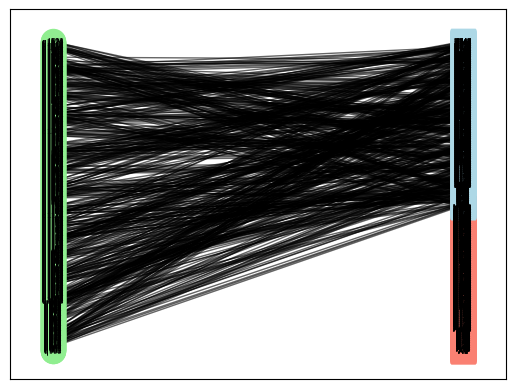

Pre-Z reduction


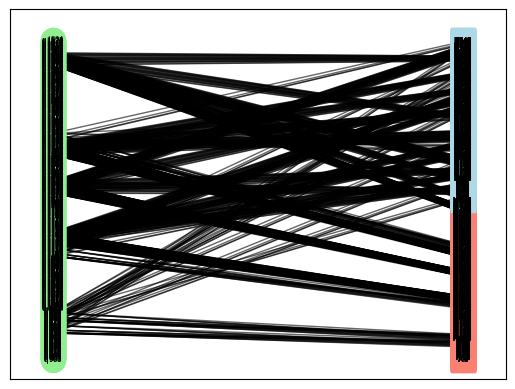

Post-Z reduction


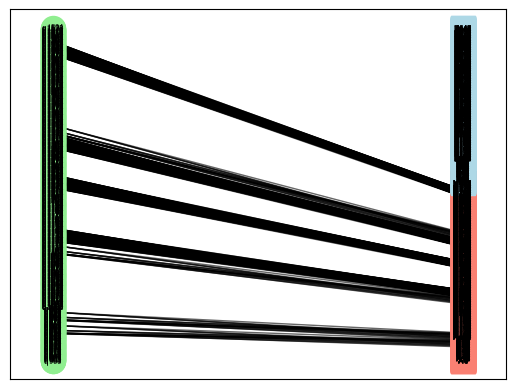

In [39]:
# Before the X reduction
Xgroups = [n**2 + (m*c1 + c2) for g in Xcombines for (c1, c2) in color_groups[g]] # qubit idx at coord (a, b) is (n**2) + (ma + b)
print("Pre-X reduction")
ctype_tannergraph(code.hx, code.hz, n**2, Xgroups)

# X reduction
Hxnew = code.hx.copy()
for Xcolorgroup in Xcombines:
    #print(f"--- COMBINING X IN COLOR GROUP {Xcolorgroup} ---")
    for (c1, c2) in color_groups[Xcolorgroup]:
        #print(f"qubit coordinate = ({c1}, {c2})")
        #print(f"qubit index = {n**2 + (m*c1 + c2)}")
        Hxnew = combinerowsF2(Hxnew, stabs_touching_qubit(Hxnew, n**2 + m*c1 + c2)) # qubit idx at coord (a, b) is (n**2) + (ma + b)
print("Post-X reduction")
ctype_tannergraph(Hxnew, code.hz, n**2, Xgroups)

# Before the Z reduction
Zgroups = [n**2 + (m*c1 + c2) for g in Zcombines for (c1, c2) in color_groups[g]] # qubit idx at coord (a, b) is (n**2) + (ma + b)
print("Pre-Z reduction")
ctype_tannergraph(code.hx, code.hz, n**2, Zgroups)

# Z reduction
Hznew = code.hz.copy()
for Zcolorgroup in Zcombines:
    #print(f"--- COMBINING Z IN COLOR GROUP {Zcolorgroup} ---")
    for (c1, c2) in color_groups[Zcolorgroup]:
        #print(f"qubit coordinate = ({c1}, {c2})")
        #print(f"qubit index = {n**2 + (m*c1 + c2)}")
        Hznew = combinerowsF2(Hznew, stabs_touching_qubit(Hznew, n**2 + m*c1 + c2))
print("Post-Z reduction")

ctype_tannergraph(code.hx, Hznew, n**2, Zgroups)

### Cutting support of the other stabilizer

Now, we must cut $X\ (Z)$ support on check-type qubits that we combined $Z\ (X)$ stabilizers on. This will remove all support to so that we can start discarding check-type qubits.

In [40]:
# Remove X support for all qubits in color groups that we combined Z stabilizers
for Zcolorgroup in Zcombines:
    #print(f"--- REMOVING ALL X SUPPORT IN COLOR GROUP {Zcolorgroup} ---")
    for (c1, c2) in color_groups[Zcolorgroup]:
        q = n**2 + (m*c1 + c2)
        #print(f"qubit coordinate = ({c1}, {c2})")
        #print(f"qubit index = {q}")
        Hxnew[:, q] = 0

# Remove Z support for all qubits in color groups that we combined X stabilizers
for Xcolorgroup in Xcombines:
    #print(f"--- REMOVING ALL Z SUPPORT IN COLOR GROUP {Xcolorgroup} ---")
    for (c1, c2) in color_groups[Xcolorgroup]:
        q = n**2 + (m*c1 + c2)
        #print(f"qubit coordinate = ({c1}, {c2})")
        #print(f"qubit index = {q}")
        Hznew[:, q] = 0

Removing check-type qubits that lost all $X$ and $Z$ support (i.e., all check-type qubits in color groups that we combined `X` or `Z` stabilizers within) and thus that we can discard. This finally gives us our reduced parity-check matrices `Hxnew` and `Hznew`.

In [41]:
def remove_supportless(Hx, Hz):
    Hx = Hx.tocsr(copy=True); Hx.eliminate_zeros()
    Hz = Hz.tocsr(copy=True); Hz.eliminate_zeros()
    keep = np.where((Hx.getnnz(axis=0) + Hz.getnnz(axis=0)) > 0)[0]
    return Hx[:, keep].tocsr(), Hz[:, keep].tocsr()

Hxnew, Hznew = remove_supportless(Hxnew, Hznew)

## Section 4: Transformation Analysis

***

### Creating the reduced code

We create a new code using our reduced parity check matrices `Hxnew` and `Hznew` and make sure that it is a valid CSS code.

In [42]:
#np.set_printoptions(threshold=np.inf, linewidth=200)
print("Old # of X stabilizers:", code.hx.shape[0])
print("New # of X stabilizers:", Hxnew.shape[0])
print("Old # of Z stabilizers:", code.hz.shape[0])
print("New # of Z stabilizers:", Hznew.shape[0])
print("Old number of check-type qubits:", code.hx.shape[1] - n**2)
print("New number of check-type qubits:", Hxnew.shape[1] - n**2)

print(Hxnew.shape, Hznew.shape)

print("****** NEW CODE TEST ******")
newcode = css_code(hx=Hxnew, hz=Hznew)
newcode.name = 'Transformed code'
newcode.test()

print("****************************************")
print(f"[[n, k, d]] = [[{code.N}, {code.K}, {code.D}]]")
print(f"[[n', k', d']] = [[{newcode.N}, {newcode.K}, {code.D}]]")
#print(newcode.compute_code_distance())

Old # of X stabilizers: 750
New # of X stabilizers: 650
Old # of Z stabilizers: 750
New # of Z stabilizers: 650
Old number of check-type qubits: 625
New number of check-type qubits: 425
(650, 1325) (650, 1325)
****** NEW CODE TEST ******
Transformed code
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -Transformed code is a valid CSS code w/ params [1325,25,nan]
****************************************
[[n, k, d]] = [[1525, 25, 13]]
[[n', k', d']] = [[1325, 25, 13]]


$\big(\bar{w}_q, \bar{w}_c\big)_X$ and $\big(\bar{w}_q^\prime, \bar{w}_c^\prime\big)_X$ (refer to Table _)

In [43]:
def avg_deg(H):
    return np.floor(H.getnnz(axis=0).mean()*1000)/1000, np.floor(H.getnnz(axis=1).mean()*1000)/1000

print(f"Original (w_q, w_c)_X: {avg_deg(code.hx)}")
print(f"Transformed (w'_q, w'_c)_X: {avg_deg(newcode.hx)}")

Original (w_q, w_c)_X: (8.807, 17.909)
Transformed (w'_q, w'_c)_X: (6.553, 13.36)


$N_{\rm 2q}^{(X)}$ and ${N'}_{\rm 2q}^{(X)}$ (refer to Table _)

In [44]:
print(f"Original: {code.hx.getnnz()}")
print(f"Transformed: {newcode.hx.getnnz()}")

Original: 13432
Transformed: 8684
